# Processing of DARTMs_injection volume dataset from Nicolas 

Software: new DARTMS module of tidyms

Dataset: Different injection volumes of serum (2 and 10 ul)

In [1]:
## Setup

########################################
## Packages

## Import tidyMS
## Since it is not yet packed, load it from the development directory
import sys

sys.path.append("D:/Projects/DARTMS/tidyms/src/")
import tidyms as ms

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import plotnine as p9
import numpy as np
import pandas as pd
import natsort

import os
import shutil
import functools
import time

import logging

logging.basicConfig(level=logging.INFO)


########################################
## Common parameters

p9.options.figure_size = (20, 12)


########################################
## Functions and others


## Object to record processing times
## useage with RecordExecutionTime():
##     code...
class RecordExecutionTime(object):
    def __init__(self, name=None):
        self.name = name
        self.start = None

    def __enter__(self):
        self.startTime = time.perf_counter()

    def __exit__(self, *args):
        duration = time.perf_counter() - self.startTime
        unit = "seconds"
        if duration > 60 * 60:
            duration = duration / 60 / 60
            unit = "hours"
        elif duration > 60:
            duration = duration / 60
            unit = "minutes"
        elif duration > 0:
            pass
        elif duration > 1 / 1e3:
            duration = duration * 1e3
            unit = "milli-seconds"
        elif duration > 1 / 1e6:
            duration = duration * 1e6
        logging.info(".. took %.1f %s to execute" % (duration, unit))


Loading BokehJS ...

## Specify the data to be loaded

INFO:root:    .. processing input file 'D:/Projects/DARTMS/Serum_InjectionVolumne/mzML/20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING.mzML'
INFO:root:       .. no spots defined for file. Spots will be detected automatically, but not used for now. Please modify the spots file 'C:\Users\CHRIST~1\AppData\Local\Temp\jq8nyd91' to include or modify them
INFO:root:       .. found new automatically detected spot from 9.14 to 308.50 seconds
INFO:root:       .. found new automatically detected spot from 325.75 to 367.36 seconds
INFO:root:       .. found new automatically detected spot from 376.50 to 419.12 seconds
INFO:root:       .. found new automatically detected spot from 427.24 to 470.87 seconds
INFO:root:       .. found new automatically detected spot from 477.98 to 521.61 seconds
INFO:root:       .. found new automatically detected spot from 529.73 to 573.37 seconds
INFO:root:       .. found new automatically detected spot from 580.47 to 624.11 seconds
INFO:root:       .. foun

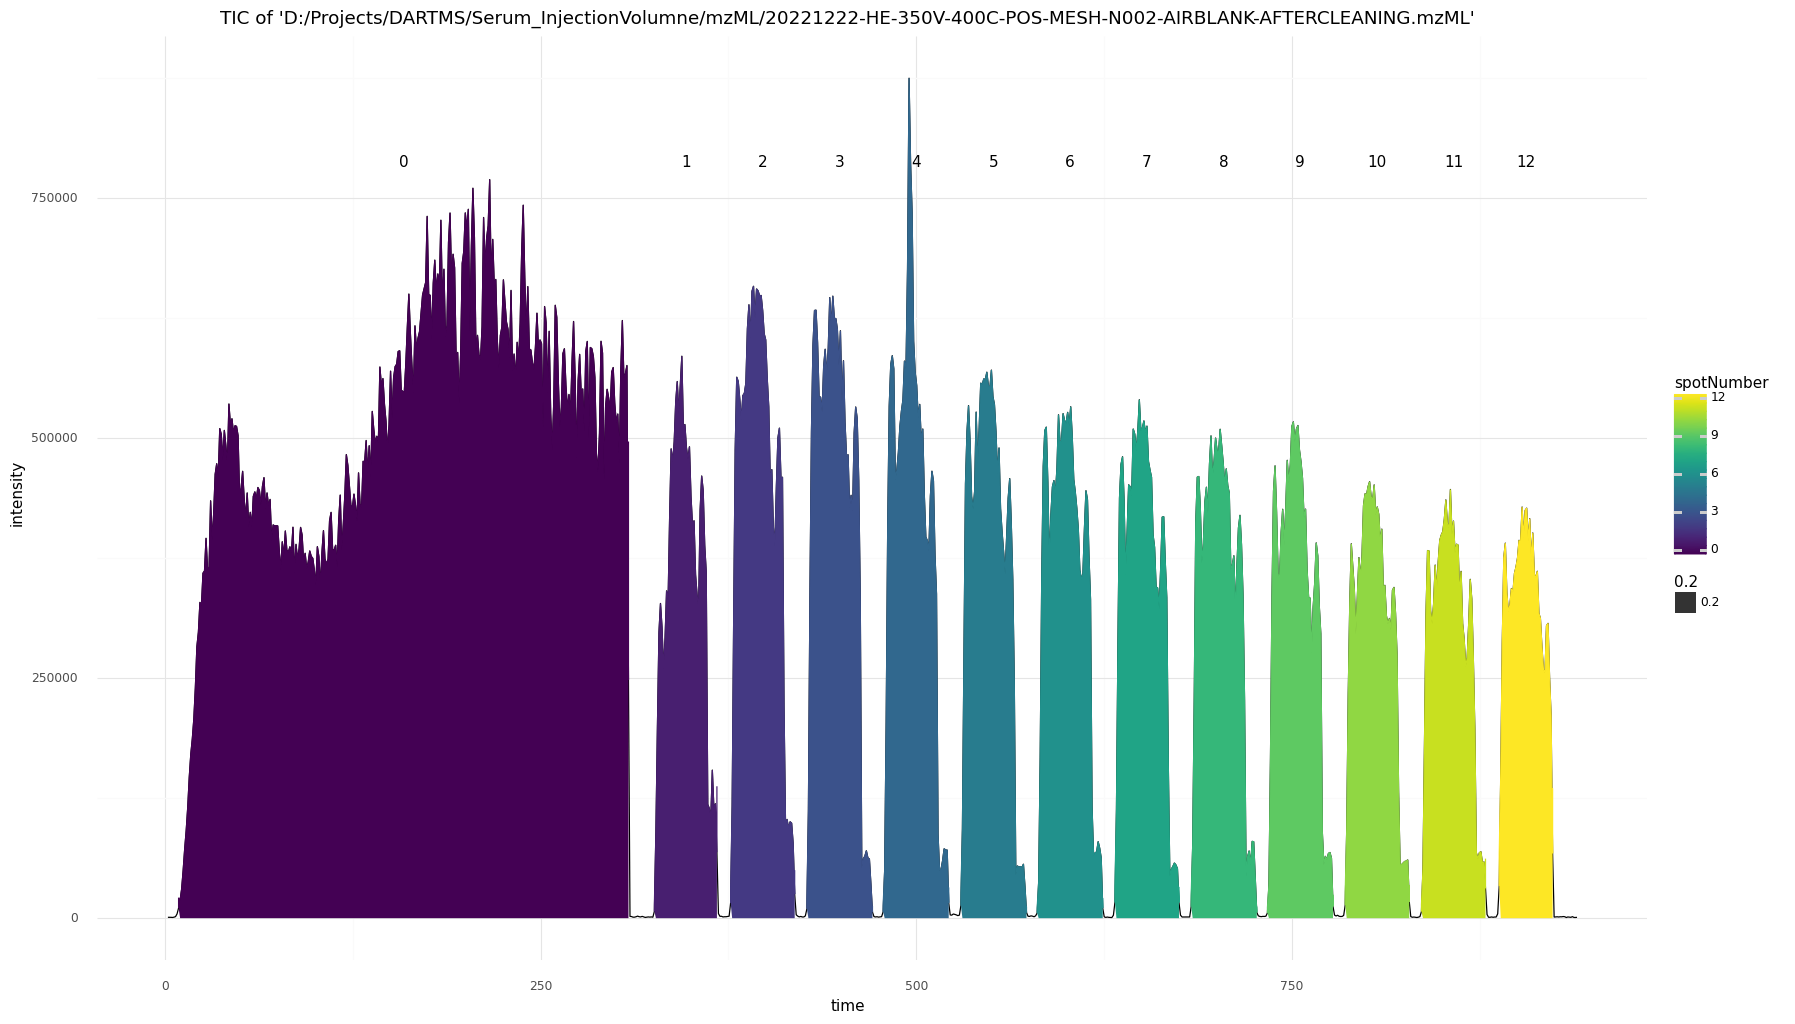

INFO:root:    .. processing input file 'D:/Projects/DARTMS/Serum_InjectionVolumne/mzML/20221222-HE-350V-400C-POS-MESH-N002-REPEATABILITY.mzML'


INFO:root:       .. no spots defined for file. Spots will be detected automatically, but not used for now. Please modify the spots file 'C:\Users\CHRIST~1\AppData\Local\Temp\0gk47epj' to include or modify them
INFO:root:       .. found new automatically detected spot from 35.52 to 229.35 seconds
INFO:root:       .. found new automatically detected spot from 246.60 to 289.22 seconds
INFO:root:       .. found new automatically detected spot from 297.34 to 339.96 seconds
INFO:root:       .. found new automatically detected spot from 348.08 to 390.70 seconds
INFO:root:       .. found new automatically detected spot from 398.82 to 442.46 seconds
INFO:root:       .. found new automatically detected spot from 450.58 to 493.20 seconds
INFO:root:       .. found new automatically detected spot from 501.32 to 544.95 seconds
INFO:root:       .. found new automatically detected spot from 552.06 to 595.70 seconds
INFO:root:       .. found new automatically detected spot from 603.81 to 647.45 seconds

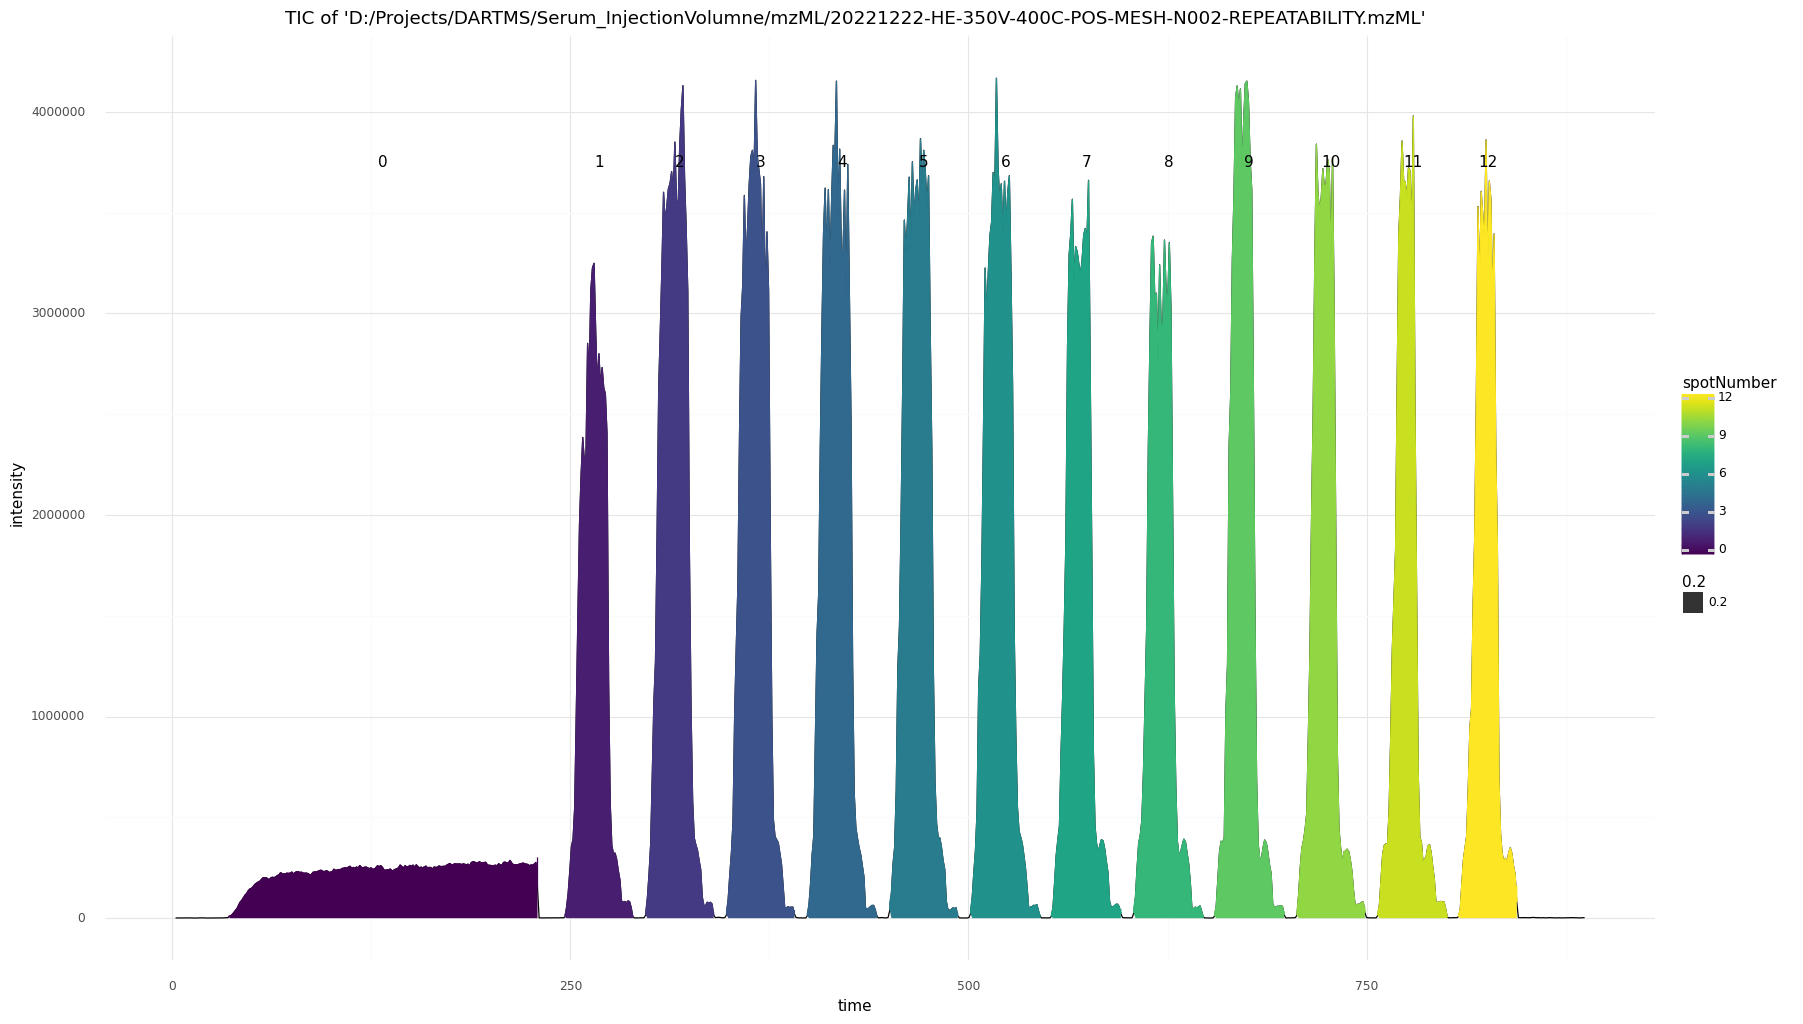

INFO:root:Shifting RTs of chronograms for improved visualization
INFO:root: Creating empty assay
INFO:root:    .. processing input file 'D:/Projects/DARTMS/Serum_InjectionVolumne/mzML/20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING.mzML'


INFO:root:       .. using only scans from RTs 321.8 - 928.5 seconds
INFO:root:       .. shifting RT by -311.8 seconds
INFO:root:       .. adding subset    0 with name 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING::Airblank_1)' (group 'Airblank', class 'unknown'), width   40.6 sec, RTs   15.0 -   55.6
INFO:root:       .. adding subset    1 with name 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING::Airblank_2)' (group 'Airblank', class 'unknown'), width   42.6 sec, RTs   64.7 -  107.3
INFO:root:       .. adding subset    2 with name 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING::Airblank_3)' (group 'Airblank', class 'unknown'), width   41.6 sec, RTs  116.5 -  158.1
INFO:root:       .. adding subset    3 with name 'VIRTUAL(20221222-HE-350V-400C-POS-MESH-N002-AIRBLANK-AFTERCLEANING::Airblank_4)' (group 'Airblank', class 'unknown'), width   42.6 sec, RTs  167.2 -  209.8
INFO:root:       .. adding subset    4 with name 'VIRTUAL(

In [2]:
## Specify the data to load

path = "D:/Projects/DARTMS/Serum_InjectionVolumne/mzML/"
ms_mode = "centroid"
instrument = "qtof"
filenames = natsort.natsorted([os.path.join(path, file) for file in os.listdir(path) if file.endswith(".mzML") and not "_rtShifted.mzML" in file])
spotFile = "./defined_spots.tsv"
temp_file = "./temp_assay.dill"

## show sample overview
ms.dartms.DartMSAssay.show_sample_overview(filenames, ms_mode=ms_mode, instrument=instrument, separation_intensity = 5e3)

## separate chronograms by retention time to improve illustration in toppview
if True:
    if os.path.exists(spotFile):
        shutil.copy2(spotFile, spotFile.replace(".tsv", "_rtShifted.tsv"))
        spotFile = spotFile.replace(".tsv", "_rtShifted.tsv")

    ## Process samples if the last results cannot be loaded
    ## Import chronograms and separate them into spots.
    with RecordExecutionTime():
        logging.info("Shifting RTs of chronograms for improved visualization")
        assay = ms.dartms.DartMSAssay.create_assay_from_chronogramFiles(
            "NA",
            filenames,
            ms_mode=ms_mode,
            instrument=instrument,
            spot_file=spotFile,
            centroid_profileMode=True,
            fileNameChangeFunction=lambda x: x.replace("20220316-HE-350V-400C-POS-", "").replace("20220316-HE-350V-500C-POS-", ""),
            rewriteRTinFiles=True,
        )
    print("")
    filenames = natsort.natsorted([os.path.join(path, file) for file in os.listdir(path) if file.endswith("_rtShifted.mzML")])
    temp_file = temp_file.replace(".dill", "_rtShifted.dill")

    logging.info("")
    logging.warning("ATTENTION: input changed to rewritten mzML files with changed RTs")

else:
    filenames = natsort.natsorted([os.path.join(path, file) for file in os.listdir(path) if file.endswith("_rtShifted.mzML")])
    temp_file = temp_file.replace(".dill", "_rtShifted.dill")
    spotFile = spotFile.replace(".tsv", "_rtShifted.tsv")


In [3]:
referenceFeatures = [
    149.02671,
    369.37817,
    369.28755,
    370.29189,
    370.3642,
    371.29333,
    371.36694,
    279.16533,
    279.23805,
    90.05728,
    90.09405,
    1077.99152,
    1078.99716,
    1017.95975,
]

params = [
    ms.dartms.Parameters(
        "set1",
        "all spectra, strict quality checks",
        [],
        {
            "results_file": "./mzML/bracketedResults_set1.featureML",
            "dill_file": "./set1.dill",
        },
    ),
    ms.dartms.Parameters(
        "set2",
        "all spectra, strict quality checks, smaller re-integration window",
        [],
        {
            "build_data_matrix__originalData_mz_deviation_multiplier_PPM": 10,

            "results_file": "./mzML/bracketedResults_set2.featureML",
            "dill_file": "./set2.dill",
        },
    ),
    ms.dartms.Parameters(
        "set3",
        "all spectra, fewer quality checks",
        [],
        {
            "calculate_consensus_spectra_for_samples__cluster_quality_check_functions": [
                functools.partial(
                    ms.dartms.cluster_quality_check_function__ppmDeviationCheck,
                    max_weighted_ppm_deviation=25,
                ),
                functools.partial(
                    ms.dartms.cluster_quality_check_function__peak_form,
                    min_correlation_for_cutoff=0.0,
                ),
            ],

            "results_file": "./mzML/bracketedResults_set3.featureML",
            "dill_file": "./set3.dill",
        },
    ),
]

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

if True:
    succeeded, failed = ms.dartms.compare_parameters_for_function(
        function_to_optimize=ms.dartms.prefab_DARTMS_dataProcessing_pipeline,
        parameter_values=params,
        spotFile=spotFile,
        dartMSFiles=filenames,
        referenceFeatures=referenceFeatures,
        referenceFeatures_allowedPPMDev=20,
    )
    succeeded, failed = pd.DataFrame(succeeded), pd.DataFrame(failed)
    print(succeeded.drop("_parameterSetComment", axis=1).to_markdown())
    if len(failed.index) > 0:
        print("Failed sets")
        print(failed.to_markdown)
    else:
        print("No failed sets")




##############################################################################
##############################################################################

Starting parameter comparison


##############################################################################
Setname: set1
Comment: all spectra, strict quality checks


exporting featureML: 100%|██████████| 2693/2693 [00:00<00:00, 6357.26it/s]




##############################################################################
Setname: set2
Comment: all spectra, strict quality checks, smaller re-integration window


exporting featureML: 100%|██████████| 2693/2693 [00:00<00:00, 5674.73it/s]




##############################################################################
Setname: set3
Comment: all spectra, fewer quality checks


exporting featureML: 100%|██████████| 2846/2846 [00:00<00:00, 5837.35it/s]




##############################################################################

Parameter comparison finished
   .. took 29.5 minutes
   .. 11 sets finished, 0 sets failed
##############################################################################
##############################################################################


|    | _parameterSet   |   _executionTime |   n(feats) |   avg(feats.MZDevPPM) |   std(feats.MZDevPPM) |   n(nan) |   r(nan) |   n(ref) |   avg(ref.MZDevPPM) |   std(ref.mzDevPPM) |
|---:|:----------------|-----------------:|-----------:|----------------------:|----------------------:|---------:|---------:|---------:|--------------------:|--------------------:|
|  0 | set1            |          298.797 |       2693 |               13.0625 |               6.54066 |    11871 | 0.183671 |       12 |            -6.57744 |             2.17241 |
|  1 | set2            |          343.258 |       2693 |               13.0625 |               6.54066 |    15609 | 0.24

Using the above table and the generated featureML files, the user can select the best parameters for their dataset. Moreover, they can directly work with the selected dataset by simply importing the respective dill file as shown in the next step

In [5]:
## Import dataset to be used
## Dataset to be used from set1

dill_file = os.path.join("./set1.dill")
dartMSAssay = ms.dartms.DartMSAssay.read_from_dill_file(dill_file)